Import necessary Libraries

In [1]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.stats as si


Set parameters

In [2]:
S0 = 100.0    # Initial stock price
K = 100.0     # Strike price
r = 0.05      # Risk-free rate
T = 1.0       # Time to maturity
kappa = 2.0   # Mean reversion rate
theta = 0.05  # Long-term average volatility
sigma = 0.3   # Volatility of volatility
rho = -0.5    # Correlation coefficient
v0 = 0.05     # Initial volatility


Calculation of option prices using Heston Model


In [3]:
def heston_characteristic_function(u, S0, K, r, T, kappa, theta, sigma, rho, v0):
   xi = kappa - rho * sigma * 1j * u
   d = np.sqrt((rho * sigma * 1j * u - xi)**2 - sigma**2 * (-u * 1j - u**2))
   g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
   C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
   D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
   return np.exp(C + D * v0 + 1j * u * np.log(S0))

def heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0):
   integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j, S0, K, r, T, kappa, theta, sigma, rho, v0))
   integral, _ = quad(integrand, 0, np.inf)
   return np.exp(-r * T) * 0.5 * S0 - np.exp(-r * T) / np.pi * integral

def heston_put_price(S0, K, r, T, kappa, theta, sigma, rho, v0):
   integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j, S0, K, r, T, kappa, theta, sigma, rho, v0))
   integral, _ = quad(integrand, 0, np.inf)
   return np.exp(-r * T) / np.pi * integral - S0 + K * np.exp(-r * T)

In [4]:
from scipy.optimize import minimize

Calculation of IV's using scipy's minimize function and heston prices vs market price

In [5]:
def heston_implied_vol(S0, K, r, T, market_price, option_type, kappa, theta, sigma, rho, v0):
    if option_type == 'call':
        model_price = lambda sigma: heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0)
    elif option_type == 'put':
        model_price = lambda sigma: heston_put_price(S0, K, r, T, kappa, theta, sigma, rho, v0)

 
    def objective_function(sigma):
        return (model_price(sigma) - market_price)**2
    
    initial_guess = 0.2
    result = minimize(objective_function, initial_guess, bounds=[(0.0001, 50)], method='L-BFGS-B')
    
    implied_vol = result.x[0]
    return implied_vol

S0 = 100  
r = 0.01 
T = 1  
kappa, theta, sigma, rho, v0 = 2, 0.2, 0.3, -0.5, 0.2  
strikes = np.linspace(80, 120, 10)  
market_prices = [18,20,29,28,15,27,10,3,5,4]  
option_type = 'call'

ivs = [heston_implied_vol(S0, K, r, T, market_price, option_type, kappa, theta, sigma, rho, v0) for K, market_price in zip(strikes, market_prices)]

ivs

C:\Users\sambu\AppData\Local\Temp\ipykernel_13684\4001385120.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, 0, np.inf)


[np.float64(0.5312028172306466),
 np.float64(0.6643398616981024),
 np.float64(0.09404092735658533),
 np.float64(0.5396094428133417),
 np.float64(3.5899958159476735),
 np.float64(1.5519603031480076),
 np.float64(4.930553343498417),
 np.float64(2.6500653987149154),
 np.float64(1.7103081101466224),
 np.float64(1.1913138657718043)]

In [6]:
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

Uses the price calculation above for a range of strikes and expiry dates to plot a 3D surface using implied_vol

c:\Users\sambu\AppData\Local\Programs\Python\Python312\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


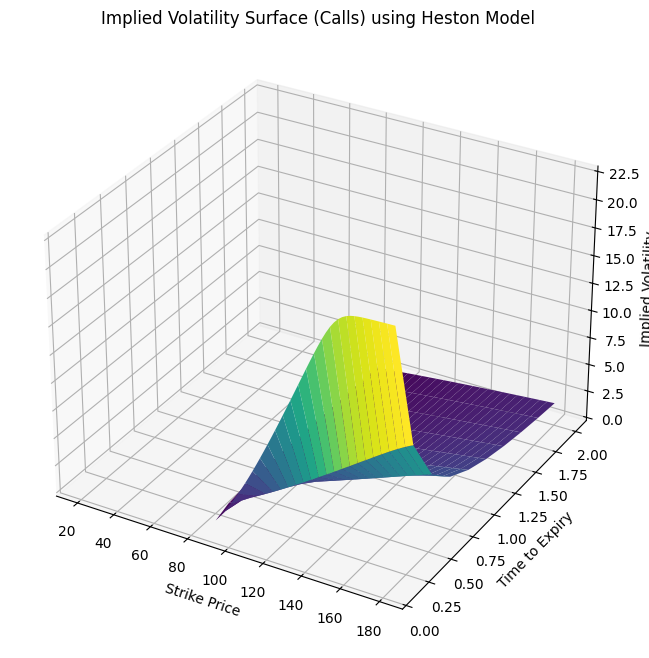

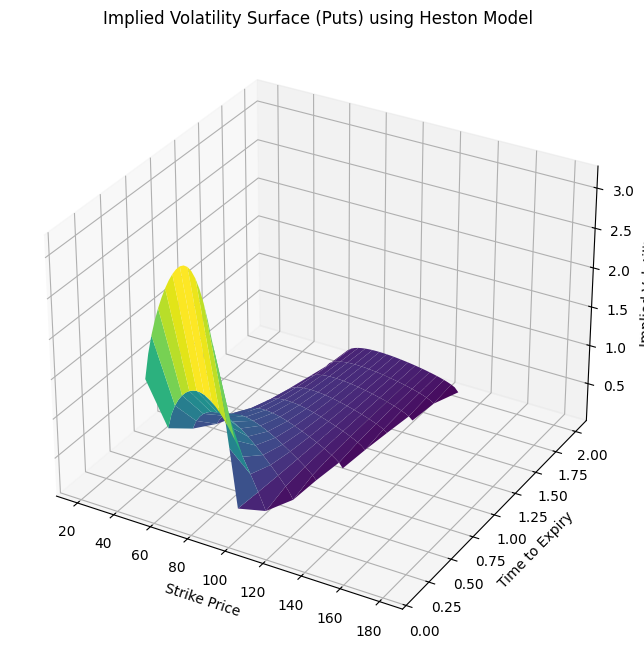

In [7]:
S0 = 100  
r = 0.01 
kappa, theta, sigma, rho, v0 = 2, 0.2, 0.3, -0.5, 0.2  

K = np.linspace(20, 180, 81, dtype=np.float64)
T = np.linspace(0.1, 2, 10, dtype=np.float64)

calls = np.array([[heston_call_price(S0, k, r, t, kappa, theta, sigma, rho, v0) for k in K] for t in T])
puts = np.array([[heston_put_price(S0, k, r, t, kappa, theta, sigma, rho, v0) for k in K] for t in T])

call_ivs = np.array([[implied_vol(float(calls[i, j]), float(S0), float(K[j]), float(T[i]), float(r), 'c') for j in range(len(K))] for i in range(len(T))])
put_ivs = np.array([[implied_vol(float(puts[i, j]), float(S0), float(K[j]), float(T[i]), float(r), 'p') for j in range(len(K))] for i in range(len(T))])

call_ivs = call_ivs.reshape(len(T), len(K))
put_ivs = put_ivs.reshape(len(T), len(K))

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, projection='3d')
K_mesh, T_mesh = np.meshgrid(K, T)
ax.plot_surface(K_mesh, T_mesh, call_ivs, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface (Calls) using Heston Model')
plt.show()

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_mesh, T_mesh, put_ivs, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface (Puts) using Heston Model')
plt.show()